<a href="https://colab.research.google.com/github/andrewright17/Homework-1-Deep-Learning/blob/problem-1.2-actual-task/MNIST_train_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1-1 Part 2

## Train on Actual Tasks

In this notebook we will be training a CNN on the MNIST data set.

### Import Libraries

In [1]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Specify GPU

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


### Model Hyperparameters

In [3]:
# Hyperparameters
#input_size = 784  # 28x28 flattened images
num_classes = 10
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### Load MNIST Dataset

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 99216806.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114171247.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31833352.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17224709.56it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### View Image

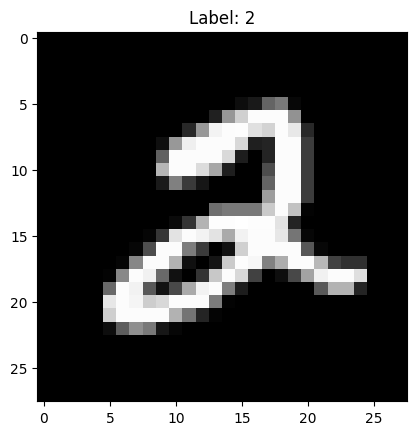

In [5]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

### Define CNN Class

In [6]:
# CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.ReLU())
        self.fc = nn.Linear(32 * 7 * 7, num_classes)  # Assuming input images are 28x28


    def forward(self, x):
       x = self.conv1(x)
       x = self.conv2(x)
       x = x.view(x.size(0), -1)
       x = self.fc(x)
       return x

### Assign Model, Loss, and Optimizer

In [7]:
model = CNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train Model and Evaluate Accuracy

In [8]:
# Training loop
total_loss = []
total_accuracy = []
for epoch in range(num_epochs):
    train_loss = 0.0

    #Training
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss * images.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    total_loss.append(train_loss)
    print(f"train loss: {train_loss}")

    #Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    total_accuracy.append(accuracy)
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



train loss: 0.2370881587266922
Accuracy of the network on the 10000 test images: 97.93 %
train loss: 0.07149962335824966
Accuracy of the network on the 10000 test images: 98.32 %
train loss: 0.0536193884909153
Accuracy of the network on the 10000 test images: 98.32 %
train loss: 0.04373057559132576
Accuracy of the network on the 10000 test images: 98.53 %
train loss: 0.03746218606829643
Accuracy of the network on the 10000 test images: 98.85 %
train loss: 0.03218705952167511
Accuracy of the network on the 10000 test images: 98.62 %
train loss: 0.027532460168004036
Accuracy of the network on the 10000 test images: 98.68 %
train loss: 0.024584151804447174
Accuracy of the network on the 10000 test images: 98.73 %
train loss: 0.021784942597150803
Accuracy of the network on the 10000 test images: 98.7 %
train loss: 0.01901765540242195
Accuracy of the network on the 10000 test images: 98.74 %


### Plot Results

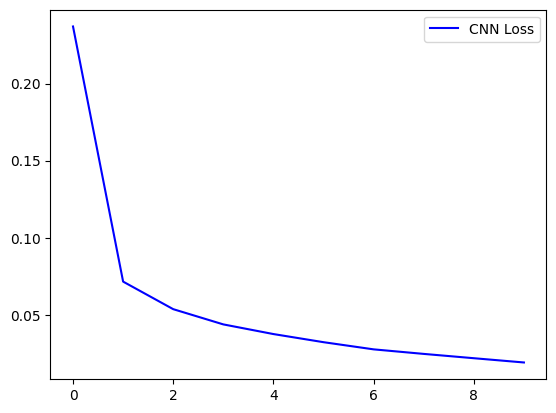

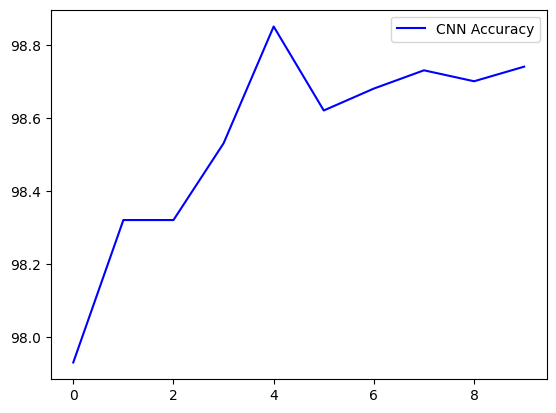

In [13]:
# Loss Plot
total_loss = torch.tensor(total_loss).cpu().data.numpy()
plt.plot(np.arange(0, len(total_loss), 1), total_loss, label = "CNN Loss", color = "blue")
plt.legend()
plt.show()

# Accuracy Plot
plt.plot(np.arange(0, len(total_accuracy), 1), np.array(total_accuracy), label = "CNN Accuracy", color = "blue")
plt.legend()
plt.show()